In [1]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
# file work
import os
import json
# computer vision
import cv2
import torch

In [2]:
# ALL DATA
json_file = '../../data/perfect.json'  # must contain input labels
image_folder = '../../data/perfect'
mask_folder = '../../data/perfect_masks'  # can be empty to start

# SAMPLE DATA
# json_file = 'sample_data/red_lasers/sample_data.json'  # must contain input labels
# image_folder = 'sample_data/red_lasers/sample_data'
# mask_folder = 'sample_data/red_lasers/sample_data_masks'  # can be empty to start

# load data
with open(json_file, 'r') as file:
    image_data = json.load(file)

In [3]:
len(image_data)

72

In [4]:
measured_df = pd.read_csv('../../data/measured.csv')
measured_df = measured_df.dropna(subset=['PhotoID', 'Laser Width', 'BodyLength1'])

In [5]:
laser_width = dict(zip(measured_df['PhotoID'], measured_df['Laser Width']))
body_length = dict(zip(measured_df['PhotoID'], measured_df['BodyLength1']))
pix_laser = dict(zip(measured_df['PhotoID'], measured_df['PixLaser1']))
pix_length = dict(zip(measured_df['PhotoID'], measured_df['PixLength1']))

In [6]:
def draw_dots(points, ax, color):
    ax.scatter(points[:, 0], points[:, 1], color=color, s=10)

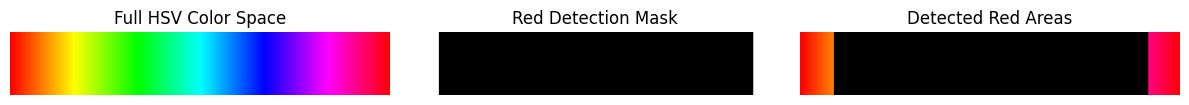

In [7]:
def plot_hsv_red_ranges():
    # Create an image with all hue values
    hsv_img = np.zeros((60, 360, 3), dtype=np.uint8)
    for i in range(360):
        hsv_img[:, i, 0] = i / 2  # Hue ranges from 0 to 180 in OpenCV
        hsv_img[:, i, 1] = 255   # Full Saturation
        hsv_img[:, i, 2] = 255   # Full Value

    # Convert to BGR for display with matplotlib
    bgr_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

    # Define red ranges
    low_red1 = np.array([0, 120, 70])
    high_red1 = np.array([15, 255, 255])
    low_red2 = np.array([165, 120, 70])
    high_red2 = np.array([180, 255, 255])

    # Create masks for the red ranges
    red_mask1 = cv2.inRange(hsv_img, low_red1, high_red1)
    red_mask2 = cv2.inRange(hsv_img, low_red2, high_red2)
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)

    # Apply masks to HSV image
    red_areas_img = cv2.bitwise_and(bgr_img, bgr_img, mask=red_mask)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(bgr_img)
    plt.title('Full HSV Color Space')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(red_mask, cmap='gray')
    plt.title('Red Detection Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(red_areas_img)
    plt.title('Detected Red Areas')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

plot_hsv_red_ranges()

37 images with less than 10 percent error


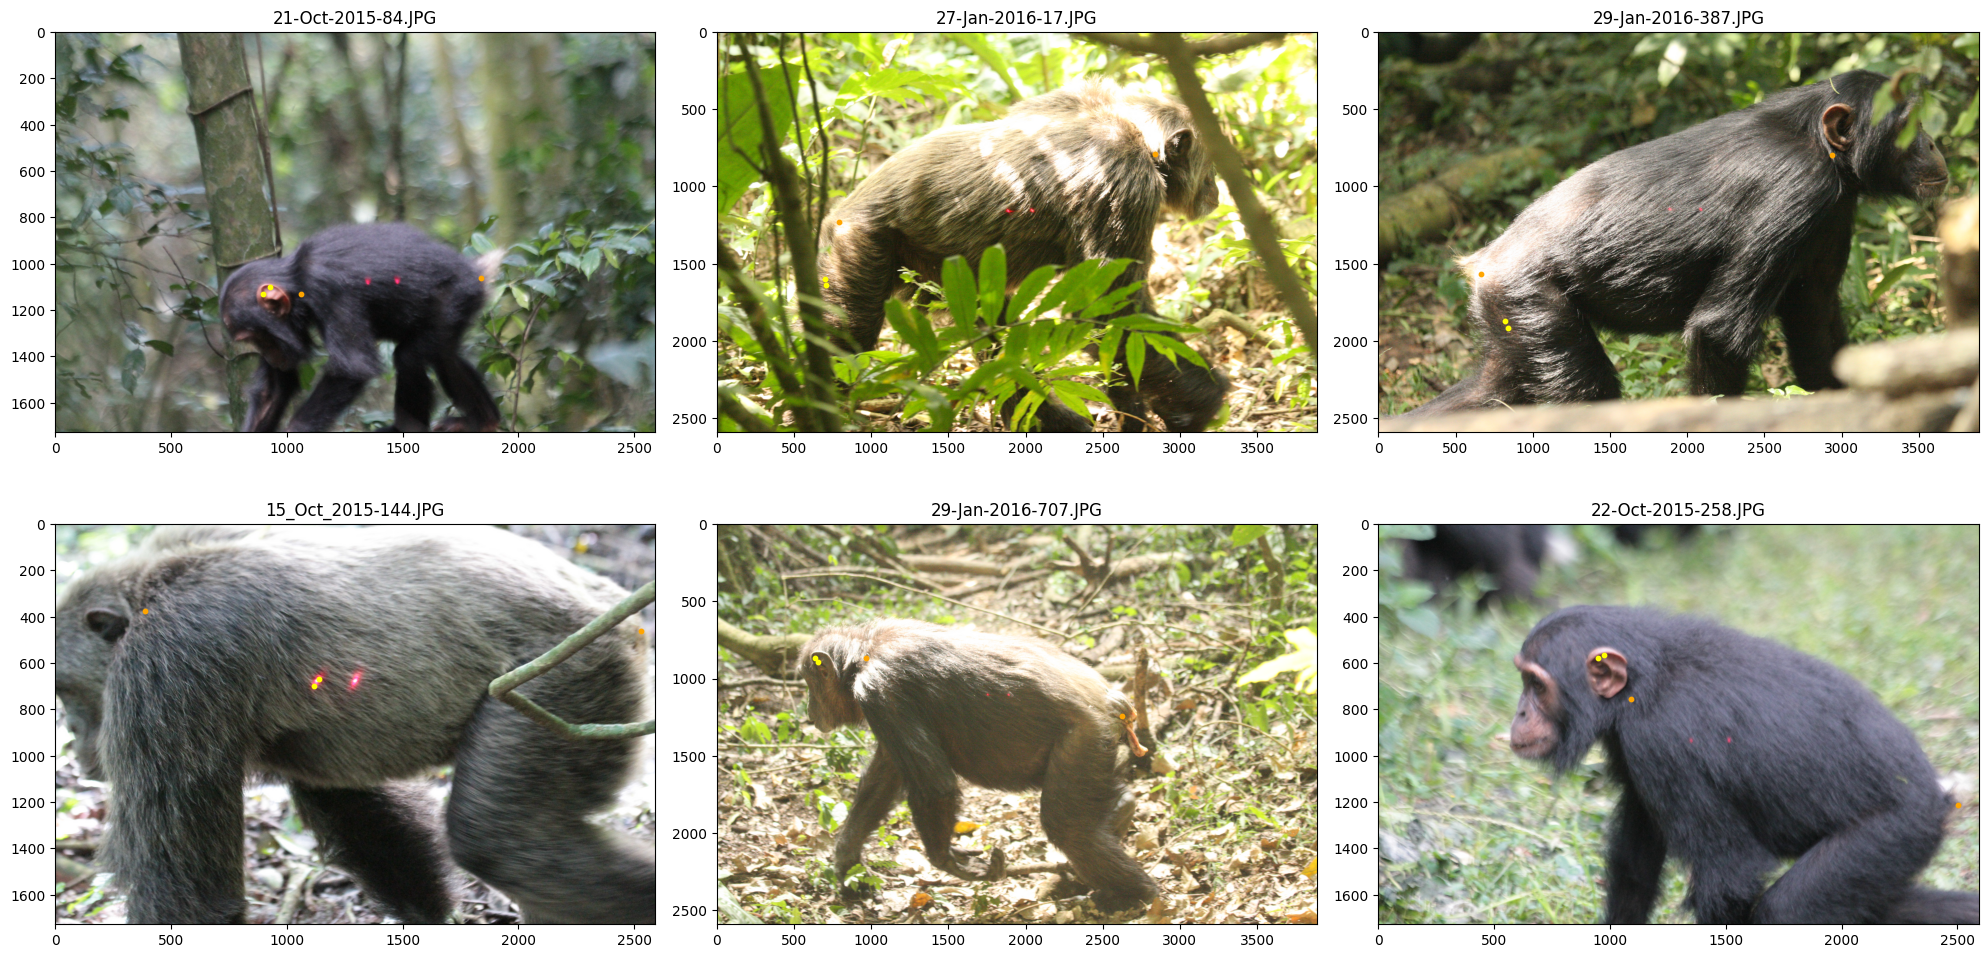

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
idx = 0
# iterate through each entry in json
count = 0
errors = []
names = []
for image_name, info in image_data.items():
    try:
        # distances in pixels
        laser_points = info['laser_points']
        body_points = info['shoulder_rump']

        # calculate ratio
        laser_dist = round(math.dist(laser_points[0], laser_points[1]), 1)
        body_dist = round(math.dist(body_points[0], body_points[1]), 1)
        ratio = laser_dist / body_dist

        # lookup laser width
        photo_id = image_name.split('.')[0]
        laser_in = laser_width[photo_id]
        # compare results
        predicted_length = laser_in / ratio
        true_length = body_length[photo_id]
        error = round(abs(predicted_length - true_length) / true_length, 3)
        errors.append(error * 100)
        
        if error < 0.10:
            count += 1
            
        if error > 2:
            names.append(image_name)
            image_path = os.path.join(image_folder, image_name)
            # load image
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for plotting

            # plot image
            axs[idx].imshow(img)
            draw_dots(np.array(body_points), axs[idx], 'orange')
            draw_dots(np.array(laser_points), axs[idx], 'yellow')
            axs[idx].set_title(image_name)
            idx += 1
    except:
        pass

print(f"{count} images with less than 10 percent error")
plt.tight_layout()
plt.show()

In [10]:
names

['21-Oct-2015-84.JPG',
 '27-Jan-2016-17.JPG',
 '29-Jan-2016-387.JPG',
 '15_Oct_2015-144.JPG',
 '29-Jan-2016-707.JPG',
 '22-Oct-2015-258.JPG']

In [11]:
image_data['21-Oct-2015-84.JPG']

{'input_point': [1388, 962],
 'mask': '21-Oct-2015-84_mask.png',
 'laser_points': [[898, 1129], [926, 1100]],
 'shoulder_rump': [[1060, 1129], [1840, 1060]]}

In [21]:
def find_laser_points(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Convert to HSV and grayscale
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define a range for bright red color
    lower_red = np.array([0, 150, 150])
    upper_red = np.array([10, 255, 255])
    lower_red2 = np.array([170, 150, 150])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for red color
    mask1 = cv2.inRange(hsv, lower_red, upper_red)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)

    # Mask for the darker fur
    dark_fur_mask = cv2.inRange(gray, 0, 60)

    # Combine the masks to only keep red points on dark fur
    combined_mask = cv2.bitwise_and(red_mask, dark_fur_mask)

    # Find contours in the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store coordinates of laser points
    laser_points = []

    # Check each contour
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 1 < area < 50:  # Assumed laser point size range
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                x = int(M["m10"] / M["m00"])
                y = int(M["m01"] / M["m00"])
                # Validate that the point is not on the ear or other non-fur area
                if gray[y, x] < 60:  # Assuming the ear or other areas are brighter
                    laser_points.append((x, y))

    # If we have more than two points, we need additional logic to select the correct two
    if len(laser_points) > 2:
        # Sort the points based on their intensity (brightest first)
        laser_points.sort(key=lambda point: image[point[1], point[0], 2], reverse=True)
        # Take the top two brightest points
        laser_points = laser_points[:2]

    return laser_points

Laser Detection: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


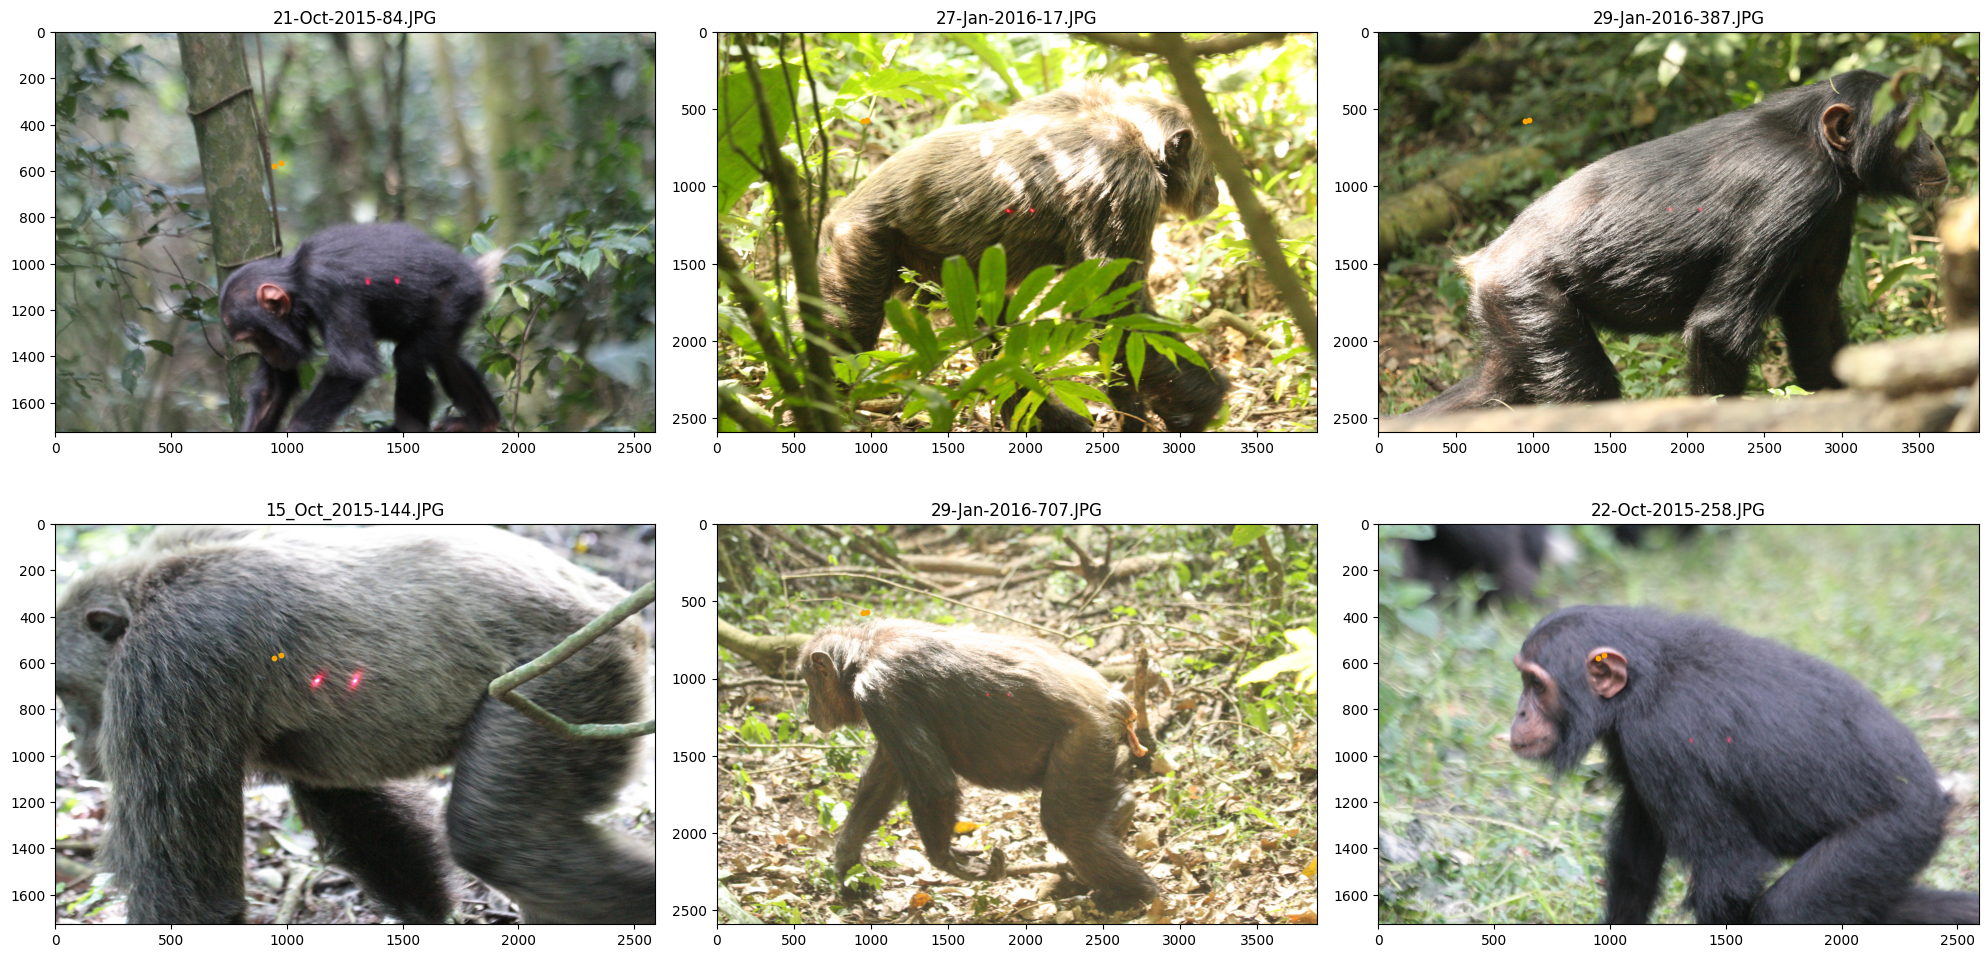

In [22]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()
idx = 0
for image_name in tqdm(names, desc='Laser Detection'):
    image_path = os.path.join(image_folder, image_name)
    points = find_laser_points(image_path)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # plot image
    axs[idx].imshow(img)
    draw_dots(np.array(laser_points), axs[idx], 'orange')
    axs[idx].set_title(image_name)
    idx += 1

plt.tight_layout()
plt.show()

In [15]:
names

['21-Oct-2015-84.JPG',
 '27-Jan-2016-17.JPG',
 '29-Jan-2016-387.JPG',
 '15_Oct_2015-144.JPG',
 '29-Jan-2016-707.JPG',
 '22-Oct-2015-258.JPG']

In [9]:
print("mean:", np.mean(errors))
print("median:", np.median(errors))
print("std:", np.std(errors))

mean: 32.96463414634146
median: 7.1499999999999995
std: 54.28375171702769


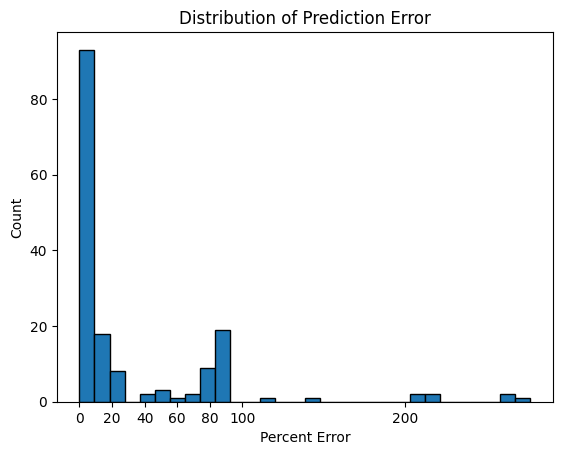

In [10]:
import matplotlib.pyplot as plt
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel("Percent Error")
plt.xticks([0,20,40,60,80,100,200])
plt.ylabel("Count")
plt.title("Distribution of Prediction Error")
plt.show()